## S&P 500 Prediction Random Forest Classifier

In [1]:
import pandas as pd

In [68]:
sp500 = pd.read_csv("data/sp_daily.csv", index_col=0, parse_dates=True)
sp500 = sp500.dropna()

sp500.head()

,spindx,sprtrn
caldt,,
1962-07-03,56.49,0.011278
1962-07-05,56.81,0.005665
1962-07-06,56.17,-0.011266
1962-07-09,56.55,0.006765
1962-07-10,57.20,0.011494


In [69]:
sp500.index

DatetimeIndex(['1962-07-03', '1962-07-05', '1962-07-06', '1962-07-09',
               '1962-07-10', '1962-07-11', '1962-07-12', '1962-07-13',
               '1962-07-16', '1962-07-17',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='caldt', length=15731, freq=None)

<Axes: xlabel='caldt'>

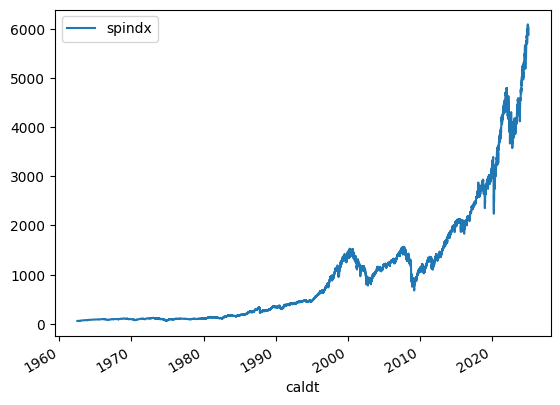

In [70]:
sp500.plot.line(y="spindx", use_index=True)

Add a new column which is the price of the S&P 500 in 3 months (one month has 21 trading days on average)

In [71]:
sp500["price_in_3months"] = sp500["spindx"].shift(-63)

In [72]:
sp500

,spindx,sprtrn,price_in_3months
caldt,,,
1962-07-03,56.49,0.011278,56.10
1962-07-05,56.81,0.005665,56.16
1962-07-06,56.17,-0.011266,56.70
1962-07-09,56.55,0.006765,57.07
1962-07-10,57.20,0.011494,57.07
...,...,...,...
2024-12-24,6040.04,0.011043,NaN
2024-12-26,6037.59,-0.000406,NaN
2024-12-27,5970.84,-0.011056,NaN


Create a new column with the target. It is 1 if the S&P 500 went up during the following three months and 0 if it went down.

In [73]:
sp500["Target"] = (sp500["price_in_3months"] > sp500["spindx"]).astype(int)

In [74]:
sp500

,spindx,sprtrn,price_in_3months,Target
caldt,,,,
1962-07-03,56.49,0.011278,56.10,0
1962-07-05,56.81,0.005665,56.16,0
1962-07-06,56.17,-0.011266,56.70,1
1962-07-09,56.55,0.006765,57.07,1
1962-07-10,57.20,0.011494,57.07,0
...,...,...,...,...
2024-12-24,6040.04,0.011043,NaN,0
2024-12-26,6037.59,-0.000406,NaN,0
2024-12-27,5970.84,-0.011056,NaN,0


The market could have shifted fundamentally and some of the old data may not be as useful when making future prediction. Therefore drop everything before 1990.

In [75]:
sp500 = sp500.loc["1990-01-01":].copy()

In [76]:
sp500

,spindx,sprtrn,price_in_3months,Target
caldt,,,,
1990-01-02,359.69,0.017799,338.70,0
1990-01-03,358.76,-0.002586,343.64,0
1990-01-04,355.67,-0.008613,341.09,0
1990-01-05,352.20,-0.009756,340.73,0
1990-01-08,353.79,0.004514,340.08,0
...,...,...,...,...
2024-12-24,6040.04,0.011043,NaN,0
2024-12-26,6037.59,-0.000406,NaN,0
2024-12-27,5970.84,-0.011056,NaN,0


In [77]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators: number of individual trees we want to train. The higher the number, the more accurate the model will be (up to a limit).
# min_samples_split: protects from overfitting (random forests tend to overfit by building deep trees). The higher the number, the less overfitting but also less accuracy.
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)

# Split the data into training and testing sets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["spindx", "sprtrn"] #set predictor columns
model.fit(train[predictors], train["Target"]) #use predictor columns to fit the model

RandomForestClassifier(min_samples_split=100, random_state=42)

Measure how accurate the model is: when we said the market would go up, did it actually go up?


In [78]:
from sklearn.metrics import precision_score

# let the model predict the target variable on the test set
preds = model.predict(test[predictors])

In [79]:
# turn the predictions into a DataFrame to work with easyer
preds = pd.Series(preds, index=test.index, name="Predictions")

In [80]:
preds

caldt
2024-08-09    1
2024-08-12    1
2024-08-13    1
2024-08-14    1
2024-08-15    1
             ..
2024-12-24    1
2024-12-26    1
2024-12-27    1
2024-12-30    1
2024-12-31    1
Name: Predictions, Length: 100, dtype: int64

In [81]:
precision_score(test["Target"], preds)

0.37

In [82]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='caldt'>

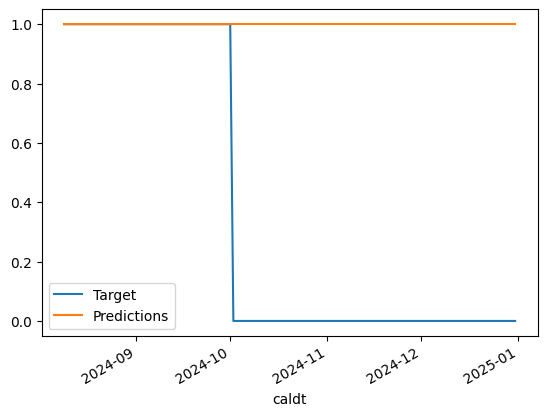

In [83]:
combined.plot()

# Test the Algorithm
Currently, we only test against the last 100 days. But if you build a real world stock predictor model, you want to test it across multiple years to give you confidence that it works in multiple different scenarios

In [ ]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data (0 or 1)
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")

    combined = pd.concat([test["Target"], preds], axis=1)
    
    # Return predictions as a Series with the same index as the test data
    return combined

In [85]:
def backtest(data, model, predictors, start=2500, step=250):
    """
    Backtest the model on the given data.
    Parameters:
        data (DataFrame): The data to backtest on.
        model: The model to use for predictions.
        predictors (list): The list of predictor columns.
        start (int): The starting index for the backtest. Every trading year has around 250 trading days.
        2500 is around 10 years. Train first model on 10 years of data.
        step (int): The step size for the backtest. Train a model every 250 days (1 trading year).
    """
    # list of dataframes where each dataframe is a prediction for a single year
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        # Split the data into training and testing sets
        train = data.iloc[:i].copy() # all the years prior to the current year
        test = data.iloc[i:i + step].copy() # the current year
        
        # Make predictions using the predict function
        preds = predict(train, test, predictors, model)
        
        # Append predictions to the list
        all_predictions.append(preds)
    
    # Concatenate all predictions into a single DataFrame
    results = pd.concat(all_predictions)
    return results

In [86]:
predictions = backtest(sp500, model, predictors)

How many days our model predicts the market to go up (1) or down (0).

In [87]:
predictions["Predictions"].value_counts()

Predictions
1    4080
0    2237
Name: count, dtype: int64

How percise the model predicted if the market goes up or down.

In [88]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6514705882352941

When we said the market would go up in the next 3 months, it went up 65.15% of the time

Is that good or not? As a benchmark we can look at the percentage of days where the market actually went up for the next 3 months.

In [89]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.658224
0    0.341776
Name: count, dtype: float64

The S&P 500 went in the days we were looking at actually 65.82%. Whis is higher than our model's 65.15% which means we would have been better off just holding the S&P 500 all the time.

## Add more predictors to our model, see if it improves accuracy

Create rolling averages

In [90]:
# mean closing price in the laset 2 days, last trading week (5 days), last 3 months (60 days), last 1 year (250 days), last 4 years (1000 days) 
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_means = sp500["spindx"].rolling(horizon).mean()

    rolling_means = sp500["spindx"].rolling(horizon).mean()
    ratio_column = f"spindx_ratio_{horizon}"
    sp500[ratio_column] = sp500["spindx"] / rolling_means  # Use the Series directly

    # number of days in the past horizon that the price actually increased
    trend_column = f"spindx_trend_{horizon}"
    
    # how many days in the past horizon the price actually increased (trend)
    sp500[trend_column] = sp500["sprtrn"].shift(1).rolling(horizon).apply(lambda x: (x > 0).sum(), raw=True)

    new_predictors += [ratio_column, trend_column]


In [91]:
sp500

,spindx,sprtrn,price_in_3months,Target,spindx_ratio_2,spindx_trend_2,spindx_ratio_5,spindx_trend_5,spindx_ratio_60,spindx_trend_60,spindx_ratio_250,spindx_trend_250,spindx_ratio_1000,spindx_trend_1000
caldt,,,,,,,,,,,,,,
1990-01-02,359.69,0.017799,338.70,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,358.76,-0.002586,343.64,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,355.67,-0.008613,341.09,0,0.995675,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,352.20,-0.009756,340.73,0,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,353.79,0.004514,340.08,0,1.002252,0.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.04,0.011043,NaN,0,1.005491,2.0,1.017383,2.0,1.023002,35.0,1.115492,144.0,1.337187,530.0
2024-12-26,6037.59,-0.000406,NaN,0,0.999797,2.0,1.011334,3.0,1.021639,35.0,1.114008,144.0,1.335961,531.0
2024-12-27,5970.84,-0.011056,NaN,0,0.994441,1.0,0.996689,3.0,1.009600,35.0,1.100716,143.0,1.320541,530.0


In [92]:
sp500 = sp500.dropna()

In [94]:
sp500

,spindx,sprtrn,price_in_3months,Target,spindx_ratio_2,spindx_trend_2,spindx_ratio_5,spindx_trend_5,spindx_ratio_60,spindx_trend_60,spindx_ratio_250,spindx_trend_250,spindx_ratio_1000,spindx_trend_1000
caldt,,,,,,,,,,,,,,
1993-12-14,463.06,-0.005669,467.01,1,0.997158,1.0,0.996617,2.0,1.000283,32.0,1.028046,128.0,1.176082,513.0
1993-12-15,461.84,-0.002635,469.42,1,0.998681,1.0,0.995899,1.0,0.997328,32.0,1.025151,127.0,1.172676,512.0
1993-12-16,463.34,0.003248,470.90,1,1.001621,0.0,0.999495,1.0,1.000311,32.0,1.028274,126.0,1.176163,512.0
1993-12-17,466.38,0.006561,471.06,1,1.003270,1.0,1.004991,2.0,1.006561,32.0,1.034781,127.0,1.183537,513.0
1993-12-20,465.85,-0.001136,468.54,1,0.999431,2.0,1.003784,3.0,1.005120,32.0,1.033359,128.0,1.181856,514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,5722.26,-0.001861,6040.04,1,0.999069,2.0,1.000747,3.0,1.033954,37.0,1.133125,148.0,1.309461,528.0
2024-09-26,5745.37,0.004039,6037.59,1,1.002015,1.0,1.003674,3.0,1.037391,36.0,1.136400,147.0,1.314047,528.0
2024-09-27,5738.17,-0.001253,5970.84,1,0.999373,1.0,1.001171,3.0,1.035464,36.0,1.133675,147.0,1.311687,528.0


## Update the model with the new predictors

In [108]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=50, random_state=42)

In [129]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data
    preds = model.predict_proba(test[predictors])[:,1]  # Get the probability that the stock goes up

    pred_prob = pd.Series(preds.copy(), index=test.index, name="Pred_probability")
    #set a high threshold for the prediction to be true
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")

    combined = pd.concat([test["Target"], preds, pred_prob], axis=1)
    
    # Return predictions as a Series with the same index as the test data
    return combined

In [130]:
predictions = backtest(sp500, model, new_predictors)

In [131]:
predictions["Predictions"].value_counts()

Predictions
1.0    4495
0.0     759
Name: count, dtype: int64

In [132]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6967741935483871

When we predicted that the stock goes up, in 69.99% of the time it will actually go up!

In [133]:
predictions

,Target,Predictions,Pred_probability
caldt,,,
2003-11-14,1,1.0,0.909006
2003-11-17,1,1.0,0.881822
2003-11-18,1,1.0,0.872493
2003-11-19,1,1.0,0.883061
2003-11-20,1,1.0,0.878155
...,...,...,...
2024-09-25,1,1.0,0.637294
2024-09-26,1,1.0,0.885636
2024-09-27,1,1.0,0.884202
